In [20]:
''' 
objective 190811: work on creating a depth-first search and breadth-first search 
    example here, then transferring back to a python script. using jupyter 
    notebook because of it's rapid prototyping capability

objective 190814: work on creating iterative deepening search
objective 190814: work on heuristic search, starting with A*

random maze generator: https://keesiemeijer.github.io/maze-generator/
'''

import numpy as np
import matplotlib.pyplot as plt
import time
import PIL.Image as pil
# setup functions
def plotgrid(gridarr,start,end,fsize=4):
    ''' ensure that plot comes out nicely formatted '''
    nrows,ncols = gridarr.shape    
    f,p=plt.subplots(figsize=[fsize]*2)
    p.imshow(gridarr,cmap='gray')
    xticks=np.arange(0,ncols+1)-0.5
    yticks=np.arange(0,nrows+1)-0.5
    xlims=[xticks.min(),xticks.max()]
    ylims=[yticks.min(),yticks.max()]
    p.set_xticks(xticks,minor=True)
    p.set_yticks(yticks,minor=True)
    p.grid(b=True,which='minor')
    p.plot(*start[::-1],'ro')
    p.plot(*end[::-1],'rx')
    return f,p
def plotans(ax,anspath,ansgrid,color=[0,1,0]):
    w=ansgrid.shape[1]
    coords = np.array(path2coords(anspath,w))
    x=coords[:,1]
    y=coords[:,0]
    ax.plot(x,y,color=color)
def canGoInDir(arr,coord,direction):
    ''' 
    create a map that says whether a point can go in a given direction. 
        alternative to making a tree in the typical sense. 
        only works with orthogonal directions (no diagonals coded here)
    '''
    row,col=coord
    if(direction==0):
        # check if can go 'up'
        if(row==0): return False # at top row
        elif(arr[row-1,col]==0): return False # occupied
        else: return True
    elif(direction==1): 
        # check if can go 'right'
        if(col==arr.shape[1]-1): return False # at right-most column
        elif(arr[row,col+1]==0): return False # occupied
        else: return True
    elif(direction==2): 
        # check if can go 'down'
        if(row==arr.shape[0]-1): return False # at bottom row
        elif(arr[row+1,col]==0): return False # occupied
        else: return True
    elif(direction==3):
        # check if can go 'left'
        if(col==0): return False # at left-most column 
        elif(arr[row,col-1]==0): return False # occupied
        else: return True
    else: print('error: not a valid direction')

def coord2cellnum(coord,gridwidth):
    ''' assume coordinate is (row,col) '''
    return coord[0]*gridwidth+coord[1]
def cellnum2coord(num,gridwidth):
    i=1
    while(i*gridwidth<=num):i+=1
    i-=1
    return [i,num-i*gridwidth]
def makeAdjList(arr):
    ''' create adjacency list '''
    adjList = dict()
    w=arr.shape[1]
    for i,irow in enumerate(arr):
        for j,jcol in enumerate(irow):
            if(arr[i,j]!=0):
                # not empty
                ilist = []
                if(canGoInDir(arr,[i,j],0)): ilist.append((i-1)*w+j) # can go up
                if(canGoInDir(arr,[i,j],1)): ilist.append(i*w+(j+1)) # right
                if(canGoInDir(arr,[i,j],2)): ilist.append((i+1)*w+j) # down
                if(canGoInDir(arr,[i,j],3)): ilist.append(i*w+(j-1)) # left
                cellNo = int(i*arr.shape[1]+j)
                adjList[cellNo] = ilist
    return adjList
def path2coords(pathlist,gridwidth):
    w=gridwidth;coords = []
    for ipoint in pathlist:
        coords.append( cellnum2coord(ipoint,w) )
    return coords

''' create a desired map and generate accompanying adjacency list '''

# grid 4 (dungeon problem grid)
grid = np.ones((5,7))
grid[0,3]=0
grid[1,1]=0
grid[1,5]=0
grid[2,1]=0
grid[3,2]=0
grid[3,3]=0
grid[4,0]=0
grid[4,2]=0
grid[4,5]=0
loc_start=[0,0]
loc_end  =[4,3] # row/col format

print('map created')

w=grid.shape[1]
st = coord2cellnum(loc_start,w)
en = coord2cellnum(loc_end,w)
print('start / end points created')

adj=makeAdjList(grid)
print('adjacency list created')

map created
start / end points created
adjacency list created


In [2]:
''' bfs implementation '''
# version1: just see if you can find a solution

def bfs(_adjlist,options,goal,history=None,oldoptions=None):
    ''' simple attempt at bfs. added "history" to properly keep track of where things have been 
    INPUTS: 
        * _adjlist: adjacency list. essentially a list of new available paths
        * options: starting location. internally, list of current options
        * goal: end point to reach.
    '''
    if(type(options)!=list):
        # first iteration
        history=[options] # prevent infinite loops
        options=[options] # aka current location
    else:
        history+=options
    newoptions=[]
    prevoptions=[]
    for i,ioption in enumerate(options): # for each currently known option...
        if(ioption==goal):
            print('solved!')
            return [ioption] # return solution
        # while generating new paths, remember old ones
        for inew in _adjlist[ioption]:
            if(inew not in history):
                newoptions.append(inew)
                prevoptions.append(ioption)
    if(len(newoptions)>0):
        # can continue
        path = bfs(_adjlist,newoptions,goal,history.copy(),prevoptions.copy())
        if(type(path)==list):
            # if a solution is found, path represents correct item in newoptions
            # finding the index of that option leads to the right previous option
            iloc=newoptions.index(path[0])
            path.insert(0,prevoptions[iloc])
            return path
    else:
        print('no solution found')
        return None


In [3]:
''' demonstrate two examples: a pass and a fail '''
print('fail test:',bfs(adj,st,3))
print('--------')
print('success:',bfs(adj,st,en))

no solution found
fail test: None
--------
solved!
success: [0, 1, 2, 9, 10, 11, 18, 25, 32, 31]


In [4]:
''' dfs implementation '''

def dfs(_adjlist,curr,goal,path=None,iter1=True):
    ''' second attempt at more elegant dfs. remember: key is backtracking '''
    if(type(path)==type(None)):
        # first iteration
        path=[]
    path.append(curr)
    if(curr == goal):
        print('solution found')
        return path
    res=None
    for ioption in _adjlist[curr]:
        if(ioption not in path):
            # haven't explored this location yet
            res = dfs(_adjlist,ioption,goal,path.copy(),iter1=False)
            if(res!=None):
                # have found something
                return res
    if(iter1):
        print('nothing found')
        return None

nothing found
fail: None
--------
solution found
good: [0, 1, 2, 9, 10, 11, 4, 5, 6, 13, 20, 27, 26, 19, 18, 25, 32, 31]
solution found
[0, 1, 2, 9, 10, 11, 4, 5, 6, 13, 20, 27, 26, 19, 18, 25, 32, 31]
mms: 0.0


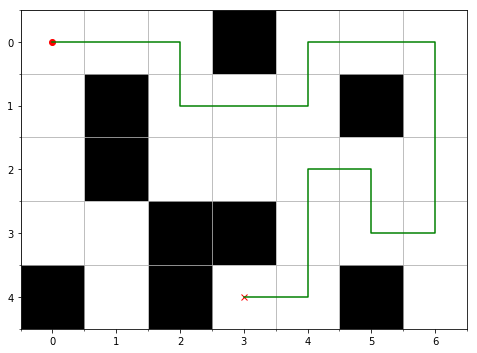

In [5]:
print('fail:',dfs(adj,st,3))
print('--------')
print('good:',dfs(adj,st,en))
# SUCCESS!!!

t0=time.time()
path = dfs(adj,st,31)
print(path)
print('mms:',(time.time()-t0)*1000000)

coords=np.array(path2coords(path,grid.shape[1]))
x=coords[:,1]
y=coords[:,0]
f,p=plotgrid(grid,loc_start,loc_end,8)

p.plot(x,y,'g-')

fail (no find): -1
--------
good: [0, 1, 2, 9, 10, 11, 18, 25, 32, 31]
[0, 1, 2, 9, 10, 11, 18, 25, 32, 31]


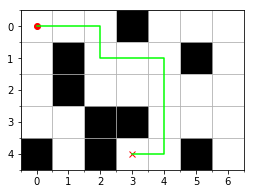

In [35]:
''' at this point, wanna start iterative deepening 
1. 
'''
def dfsB(_adjlist,curr,goal,depthlim=20,path=None,iter1=True,depthcount=0):
    ''' second attempt at more elegant dfs. remember: key is backtracking '''
    if(type(path)==type(None)):
        # first iteration
        path=[]
    path.append(curr)
    if(curr == goal):
        return path
    res=None
    flag_dplim=False
    if(depthcount>=depthlim):
        return -2 # need to define different failure modes
    for ioption in _adjlist[curr]:
        if(ioption not in path):
            # haven't explored this location yet
            res = dfsB(_adjlist,ioption,goal,depthlim,path.copy(),False,depthcount+1)
            if(res==-2):
                flag_dplim=True
            elif(res!=None):
                # have found something, not hit depth limit
                return res
    if(flag_dplim==True):
        return -2 # want to be able to know if failed because hit depth limit
    if(iter1):
        return -1 # defining different failure modes

def ids(adjlist,curr,goal):
    ''' iterative deepening '''
    dplim = 0
    maxdp=4000
    res=-2
    done = False
    while(not done and dplim<maxdp):
        res = dfsB(adjlist,curr,goal,dplim)
        if(res==-1):
            return -1
        elif(type(res)==list):
            return res
        dplim+=1
    return -1

print('fail (no find):',ids(adj,st,3))
print('--------')
sol = ids(adj,st,en)
print('good:',sol)
print(sol)
# SUCCESS!!!

f,p=plotgrid(grid,loc_start,loc_end)
plotans(p,sol,grid)


[42, 43, 44, 85, 126, 127, 128, 87, 46, 47, 48, 49, 50, 91, 132, 133, 134, 135, 136, 95, 54, 55, 56, 97, 138, 139, 140, 99, 58, 59, 60, 101, 142, 183, 224, 265, 306, 347, 388, 429, 470, 471, 472, 473, 474, 515, 556, 597, 638, 637, 636, 677, 718, 759, 800, 841, 882, 923, 964, 963, 962, 961, 960, 1001, 1042, 1043, 1044, 1085, 1126, 1167, 1208, 1249, 1290, 1331, 1372, 1413, 1454, 1495, 1536, 1537, 1538, 1497, 1456, 1457, 1458, 1459, 1460, 1419, 1378, 1379, 1380, 1381, 1382, 1423, 1464, 1505, 1546, 1587, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638]
solution found
[42, 43, 44, 85, 126, 127, 128, 87, 46, 47, 48, 49, 50, 91, 132, 133, 134, 135, 136, 95, 54, 55, 56, 97, 138, 139, 140, 99, 58, 59, 60, 101, 142, 183, 224, 265, 306, 347, 388, 429, 470, 471, 472, 473, 474, 515, 556, 597, 638, 637, 636, 677, 718, 759, 800, 841, 882, 923, 964, 963, 962, 961, 960, 1001, 1042, 1043, 1044, 1085, 1126, 1167, 1208, 1249, 1290, 1331, 1372, 1413, 1454, 1495, 1536, 1537, 1538, 1497, 145

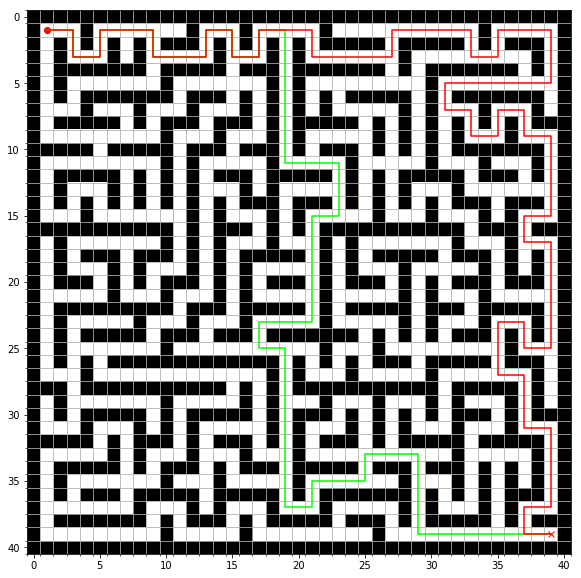

In [38]:
maze=np.array(pil.open('maze4.png').convert('L'))
st_loc = [1,1]
en_loc = np.array(maze.shape)-2
f,p=plotgrid(maze,st_loc,en_loc,fsize=10)

st1 = coord2cellnum(st_loc,maze.shape[1])
en1 = coord2cellnum(en_loc,maze.shape[1])
adj1=makeAdjList(maze)
exit
# # attempt 1
# sol = dfs(adj1,st1,en1)
# print(sol)
# plotans(p,sol,maze)
# attempt 2
sol = ids(adj1,st1,en1)
print(sol)
sol2= dfs(adj1,st1,en1)
if(type(sol)==list):
    print(sol)
    print('len:',len(sol))
    plotans(p,sol,maze)
# sol = ids(adj1,st1,en1)[0]
if(type(sol2)==list):
    print('alternate solution:',len(sol2))
    plotans(p,sol2,maze,color='red')

so, at this point, have developed bfs, dfs, and iterative deepening search (ids). next comes heuristic search, starting with A*